In [222]:
pwd

'c:\\Users\\LeeJiSu\\Desktop\\k디털플젝'

In [223]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# 형태소 추출을 위한 라이브러리
import re

# 명사 형태소 추출을 위한 라이브러리
from konlpy.tag._okt import Okt
from collections import Counter

# 불용어 제거를 위한 싸이킥런 라이브러리
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF 변환을 위한 라이브러리
from sklearn.feature_extraction.text import TfidfTransformer

# Training set / Test set 나누기
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn.metrics import confusion_matrix


In [224]:
df = pd.read_csv('new.csv')

In [225]:
df.head()

,rating,review
0,10,인피니티 사가 최고의 마무리. 이보다 더 완벽할 순 없다.\n\n캡틴 아메리카에게 ...
1,10,아이언맨으로 시작된 10년 마블 영화 팬들에 대한 위대한 엔드 프리젠트.\r\n ...
2,10,"마블시네마틱유니버스의 대서사를 마무리 짓는 작품. 슈퍼 히어로와 액션이 난무하지만,..."
3,10,11년의 긴 세월을 사랑 받아온 한편의 드라마를 어떻게하면 화려하게 장식 할 수 있...
4,9,&#39;인피니티워&#39;에서 엄청난 전투씬의 융단폭격을 퍼붓던 기조가 &#39;...


In [226]:
# rating(점수) 와 review(후기)를의 2가지 열로 구성된 4310개의 행

df.shape

(4310, 2)

In [227]:
# 리뷰의 결측치 존재 확인

df.isnull().sum()

rating      0
review    861
dtype: int64

In [228]:
# 점수는 메겼지만 리뷰는 쓰지 않은 댓글 존재
# 4310 - 3449 = 861

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4310 entries, 0 to 4309
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  4310 non-null   int64 
 1   review  3449 non-null   object
dtypes: int64(1), object(1)
memory usage: 67.5+ KB


In [229]:
# 리뷰를 작성하지 않은 공백의 결측치를 제거

# 공백을 NaN으로 변환
df.replace('', np.nan, inplace=True)

# NaN을 포함하는 행 제거
df.dropna(subset=['review'], inplace=True)

In [230]:
# 결측치 제거 확인

df.isnull().sum()

rating    0
review    0
dtype: int64

In [231]:
# 결측치 제거 이후 남은 행의 개수 확인

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3449 entries, 0 to 4309
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  3449 non-null   int64 
 1   review  3449 non-null   object
dtypes: int64(1), object(1)
memory usage: 80.8+ KB


In [232]:
# 아래의 두 리뷰를 보면 \n 이나 ㅋㅋ 등의 "특수 문자"와 "모음"이 존재하는 경우 다수
# 이들은 Text Mining을 적용할 의미가 없기에 정규표현식을 이용해 제거한다.

df['review'][0]

'인피니티 사가 최고의 마무리. 이보다 더 완벽할 순 없다.\n\n캡틴 아메리카에게 영향을 받아 변화한 하워드 스타크\n그런 과거의 아버지에게 영향을 받아 변화한 토니 스타크\n토니 스타크에게 영향을 받아 변화한 캡틴 아메리카\n\n결국 이기적이던 토니는 아이언맨으로써 모두를 위해 희생했고, 쉬지 않고 평생을 바쳐 활동하던 캡틴 아메리카는 은퇴하고 스티브 로져스의 삶을 산다..\n\n개인적으로 진짜 마블 영화 보면서 소름돋았던 것은 처음이다. 그것도 여러번이나.\n- 아이언맨의 핑거 스냅\n- 토니 스타크의 "3000만큼 사랑해"\n- 캡틴 아메리카의 "어벤져스 어셈블"\n- 스티븐 로저스와 페기 카터의 댄스\n\n아이언맨은 1편에서 했던 명대사로 끝을 맞았고, 스티븐은 1편에서 했던 약속을 지키며 끝을 맞았다'

In [233]:
df['review'][120]

'전편들이나 마블 시리즈 스토리, 캐릭터를 대강 아는 사람들은 꿀잼, 내용 모르고 처음 보는 사람들은 당연히 지루하지ㅋㅋ'

In [234]:
# 한국어 텍스트 데이터 전처리
# 리뷰의 평가 내용을 단어화해서 형태소를 추출하고,
# 그 다음 Bag of Words를 생성하여 TF-IDF 변환을 진행하겠습니다.
# 한글 형태소 분석기인 KoNLPy를 설치하는 과정

# !pip install konlpy==0.5.2 jpype1 Jpype1-py3

In [235]:
# pip install --upgrade konlpy

In [236]:
# pip install --upgrade jpype1

In [237]:
# 정규 표현식 함수 정의

def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hangul.sub('', text)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result

In [238]:
# 정규 표현식을 통해 "특수 문자"와 "모음" 제거

apply_regular_expression(df['review'][0])

'인피니티 사가 최고의 마무리 이보다 더 완벽할 순 없다캡틴 아메리카에게 영향을 받아 변화한 하워드 스타크그런 과거의 아버지에게 영향을 받아 변화한 토니 스타크토니 스타크에게 영향을 받아 변화한 캡틴 아메리카결국 이기적이던 토니는 아이언맨으로써 모두를 위해 희생했고 쉬지 않고 평생을 바쳐 활동하던 캡틴 아메리카는 은퇴하고 스티브 로져스의 삶을 산다개인적으로 진짜 마블 영화 보면서 소름돋았던 것은 처음이다 그것도 여러번이나 아이언맨의 핑거 스냅 토니 스타크의 만큼 사랑해 캡틴 아메리카의 어벤져스 어셈블 스티븐 로저스와 페기 카터의 댄스아이언맨은 편에서 했던 명대사로 끝을 맞았고 스티븐은 편에서 했던 약속을 지키며 끝을 맞았다'

In [239]:
df['review'][0]

'인피니티 사가 최고의 마무리. 이보다 더 완벽할 순 없다.\n\n캡틴 아메리카에게 영향을 받아 변화한 하워드 스타크\n그런 과거의 아버지에게 영향을 받아 변화한 토니 스타크\n토니 스타크에게 영향을 받아 변화한 캡틴 아메리카\n\n결국 이기적이던 토니는 아이언맨으로써 모두를 위해 희생했고, 쉬지 않고 평생을 바쳐 활동하던 캡틴 아메리카는 은퇴하고 스티브 로져스의 삶을 산다..\n\n개인적으로 진짜 마블 영화 보면서 소름돋았던 것은 처음이다. 그것도 여러번이나.\n- 아이언맨의 핑거 스냅\n- 토니 스타크의 "3000만큼 사랑해"\n- 캡틴 아메리카의 "어벤져스 어셈블"\n- 스티븐 로저스와 페기 카터의 댄스\n\n아이언맨은 1편에서 했던 명대사로 끝을 맞았고, 스티븐은 1편에서 했던 약속을 지키며 끝을 맞았다'

In [240]:
okt = Okt()
nouns = okt.nouns(apply_regular_expression(df['review'][0]))
nouns

['인피니티',
 '사가',
 '최고',
 '마무리',
 '이보',
 '더',
 '순',
 '캡틴',
 '아메리카',
 '영향',
 '변화',
 '하워드',
 '스타크',
 '과거',
 '아버지',
 '영향',
 '변화',
 '토니',
 '스타크',
 '토니',
 '스타크',
 '영향',
 '변화',
 '캡틴',
 '아메리카',
 '기적',
 '토니',
 '아이언맨',
 '모두',
 '위해',
 '희생',
 '쉬',
 '평생',
 '활동',
 '캡틴',
 '아메리카',
 '은퇴',
 '스티브',
 '로져스',
 '삶',
 '산다',
 '개인',
 '진짜',
 '마블',
 '영화',
 '소름',
 '것',
 '처음',
 '그것',
 '번',
 '아이언맨',
 '핑거',
 '스냅',
 '토니',
 '스타크',
 '만큼',
 '사랑',
 '캡틴',
 '아메리카',
 '어벤져스',
 '어셈블',
 '스티븐',
 '로저스',
 '페기',
 '카터',
 '댄스',
 '아이언맨',
 '편',
 '명대사',
 '끝',
 '스티븐',
 '편',
 '약속',
 '끝']

In [241]:
# 말뭉치 생성 (리뷰 전체를 담은 변수)
# 리뷰의 문자열 이외의 형태를 문자열로 변형 후 생성

corpus = " ".join([str(item) for item in df['review'].tolist()])
corpus

'인피니티 사가 최고의 마무리. 이보다 더 완벽할 순 없다.\n\n캡틴 아메리카에게 영향을 받아 변화한 하워드 스타크\n그런 과거의 아버지에게 영향을 받아 변화한 토니 스타크\n토니 스타크에게 영향을 받아 변화한 캡틴 아메리카\n\n결국 이기적이던 토니는 아이언맨으로써 모두를 위해 희생했고, 쉬지 않고 평생을 바쳐 활동하던 캡틴 아메리카는 은퇴하고 스티브 로져스의 삶을 산다..\n\n개인적으로 진짜 마블 영화 보면서 소름돋았던 것은 처음이다. 그것도 여러번이나.\n- 아이언맨의 핑거 스냅\n- 토니 스타크의 "3000만큼 사랑해"\n- 캡틴 아메리카의 "어벤져스 어셈블"\n- 스티븐 로저스와 페기 카터의 댄스\n\n아이언맨은 1편에서 했던 명대사로 끝을 맞았고, 스티븐은 1편에서 했던 약속을 지키며 끝을 맞았다 아이언맨으로 시작된 10년 마블 영화 팬들에 대한 위대한  엔드 프리젠트.\r\n  현대 영화기술의 집약.\r\n  명작중에 명작.\r\n  10년전 아이언맨 영화에서 Do not waste your life 라고 잉센이 죽기전에 한 말 그리고 이제 아이언맨이 죽어갈때 페페가 이제 쉬어도 된다고 했죠. ㅜㅜ 마블시네마틱유니버스의 대서사를 마무리 짓는 작품. 슈퍼 히어로와 액션이 난무하지만, 결국 이 영화의 가장 큰 주제는 사랑이라는 점이 마음에 든다. 앞의 이야기들을 모른다면 놓칠 수 밖에 없는 의미들이 담긴 장면들이 너무 많다. 풀리지 않았던 사소한 의문에 대한 해결도 많은 편. 차기 유니버스를 암시하는 부분들 역시도 마음에 든다. 여기까지 오는 10년 여의 시간이 참 즐거웠다. 11년의 긴 세월을 사랑 받아온 한편의 드라마를 어떻게하면 화려하게 장식 할 수 있을까, 그 해답을 보여 준 영화. 긴 세월을 달려 왔는데 한 두 편의 영화를 보고 평가 하지 말아달라!! 그들 자신에게도 우리에게도 이 한편의 11년짜리 드라마는 너무도 완벽했다. &#39;인피니티워&#39;에서 엄청난 전투씬의 융단폭격을 퍼붓던 기조가 &#39;엔드게임&#39;에선 갑자기 바껴

In [242]:
# 정규 표현식 적용

apply_regular_expression(corpus)

'인피니티 사가 최고의 마무리 이보다 더 완벽할 순 없다캡틴 아메리카에게 영향을 받아 변화한 하워드 스타크그런 과거의 아버지에게 영향을 받아 변화한 토니 스타크토니 스타크에게 영향을 받아 변화한 캡틴 아메리카결국 이기적이던 토니는 아이언맨으로써 모두를 위해 희생했고 쉬지 않고 평생을 바쳐 활동하던 캡틴 아메리카는 은퇴하고 스티브 로져스의 삶을 산다개인적으로 진짜 마블 영화 보면서 소름돋았던 것은 처음이다 그것도 여러번이나 아이언맨의 핑거 스냅 토니 스타크의 만큼 사랑해 캡틴 아메리카의 어벤져스 어셈블 스티븐 로저스와 페기 카터의 댄스아이언맨은 편에서 했던 명대사로 끝을 맞았고 스티븐은 편에서 했던 약속을 지키며 끝을 맞았다 아이언맨으로 시작된 년 마블 영화 팬들에 대한 위대한  엔드 프리젠트  현대 영화기술의 집약  명작중에 명작  년전 아이언맨 영화에서      라고 잉센이 죽기전에 한 말 그리고 이제 아이언맨이 죽어갈때 페페가 이제 쉬어도 된다고 했죠 ㅜㅜ 마블시네마틱유니버스의 대서사를 마무리 짓는 작품 슈퍼 히어로와 액션이 난무하지만 결국 이 영화의 가장 큰 주제는 사랑이라는 점이 마음에 든다 앞의 이야기들을 모른다면 놓칠 수 밖에 없는 의미들이 담긴 장면들이 너무 많다 풀리지 않았던 사소한 의문에 대한 해결도 많은 편 차기 유니버스를 암시하는 부분들 역시도 마음에 든다 여기까지 오는 년 여의 시간이 참 즐거웠다 년의 긴 세월을 사랑 받아온 한편의 드라마를 어떻게하면 화려하게 장식 할 수 있을까 그 해답을 보여 준 영화 긴 세월을 달려 왔는데 한 두 편의 영화를 보고 평가 하지 말아달라 그들 자신에게도 우리에게도 이 한편의 년짜리 드라마는 너무도 완벽했다 인피니티워에서 엄청난 전투씬의 융단폭격을 퍼붓던 기조가 엔드게임에선 갑자기 바껴 각 인물들의 정서를  정성스레 살펴나간다 기대와는 달랐지만 이건 매우 현명한 선택이며 두번째 아이맥스 감상에선 온전히 그 흐름을 즐길수 있었다 영화는 이전 마블시리즈를 상기할 뿐 아니라 고전 헐리우드 장르영화들 또한 소환한다

In [243]:
# 전체 말뭉치(corpus)에서 명사 형태소 추출

nouns = okt.nouns(apply_regular_expression(corpus))
print(nouns)

['인피니티', '사가', '최고', '마무리', '이보', '더', '순', '캡틴', '아메리카', '영향', '변화', '하워드', '스타크', '과거', '아버지', '영향', '변화', '토니', '스타크', '토니', '스타크', '영향', '변화', '캡틴', '아메리카', '기적', '토니', '아이언맨', '모두', '위해', '희생', '쉬', '평생', '활동', '캡틴', '아메리카', '은퇴', '스티브', '로져스', '삶', '산다', '개인', '진짜', '마블', '영화', '소름', '것', '처음', '그것', '번', '아이언맨', '핑거', '스냅', '토니', '스타크', '만큼', '사랑', '캡틴', '아메리카', '어벤져스', '어셈블', '스티븐', '로저스', '페기', '카터', '댄스', '아이언맨', '편', '명대사', '끝', '스티븐', '편', '약속', '끝', '아이언맨', '시작', '년', '마블', '영화', '팬', '대한', '엔드', '프리', '젠트', '현대', '영화', '기술', '집약', '명작', '명작', '년전', '아이언맨', '영화', '잉센', '말', '이제', '아이언맨', '때', '페페', '이제', '마블', '시네마', '유니버스', '서사', '마무리', '작품', '슈퍼', '히어로', '액션', '난무', '이', '영화', '가장', '주제', '사랑', '점', '마음', '앞', '이야기', '수', '의미', '장면', '의문', '대한', '해결', '편', '차기', '유니버스', '암시', '부분', '역시', '마음', '여기', '년', '여의', '시간', '년', '세월', '사랑', '온', '한편', '드라마', '게', '장식', '수', '그', '해답', '준', '영화', '세월', '두', '편의', '영화', '보고', '평가', '말', '달라', '그', '자신', '우리', '이', '한편', '년', '드라마'

In [244]:
# 형태소 빈도 탐색

counter = Counter(nouns)

counter.most_common(20)

[('영화', 1179),
 ('마블', 713),
 ('시간', 482),
 ('어벤져스', 311),
 ('아이언맨', 273),
 ('마지막', 261),
 ('최고', 256),
 ('년', 235),
 ('마무리', 226),
 ('감동', 215),
 ('사람', 215),
 ('시리즈', 209),
 ('점', 186),
 ('더', 184),
 ('것', 183),
 ('히어로', 180),
 ('진짜', 174),
 ('스토리', 169),
 ('팬', 156),
 ('액션', 154)]

In [245]:
# 두 글자 이상의 키워드는 의미를 담고 있지만
# 한 글자의 경우 '점', '더', '것', '년'과 같이 의미가 없는 경우 존재
# 때문에 한 글자 명사는 제거

available_counter = Counter({x: counter[x] for x in counter if len(x) > 1})
available_counter.most_common(20)

[('영화', 1179),
 ('마블', 713),
 ('시간', 482),
 ('어벤져스', 311),
 ('아이언맨', 273),
 ('마지막', 261),
 ('최고', 256),
 ('마무리', 226),
 ('감동', 215),
 ('사람', 215),
 ('시리즈', 209),
 ('히어로', 180),
 ('진짜', 174),
 ('스토리', 169),
 ('액션', 154),
 ('정말', 149),
 ('재미', 147),
 ('보고', 146),
 ('생각', 134),
 ('정도', 130)]

In [246]:
# 한 글자를 제거한 이후에도 여전히 '보고', '정도'와 같은 의미 없는 두 글자 존재
# 이를 제거하기 위해 불용어 사전을 활용

stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
stopwords[:10]

[['휴'],
 ['아이구'],
 ['아이쿠'],
 ['아이고'],
 ['어'],
 ['나'],
 ['우리'],
 ['저희'],
 ['따라'],
 ['의해']]

In [247]:
# 불용어 사전에 존재하는 단어 이외의 영화 분석을 위한 불용어가 필요함
# 불용어를 재정의하여 기존의 불용어 사전에 추가

movie_stopwords = ['']
for word in movie_stopwords:
    stopwords.append(word)

In [248]:
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    nouns = okt.nouns(result)
    nouns = [x for x in nouns if len(x) > 1]  # 한글자 키워드 제거
    nouns = [x for x in nouns if x not in stopwords]  # 불용어 제거
    return nouns

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(df['review'].tolist())
word_list = vect.get_feature_names_out()
count_list = bow_vect.toarray().sum(axis=0)

In [249]:
# 단어 리스트

word_list

array(['가격', '가기', '가까이', ..., '힐링', '힘들드', '힘들엇습니'], dtype=object)

In [250]:
# 각 단어가 전체 리뷰중에 등장한 총 횟수

count_list

array([1, 1, 2, ..., 2, 1, 1], dtype=int64)

In [251]:
# 각 단어의 리뷰별 등장 횟수

bow_vect.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [252]:
bow_vect.shape

(3449, 3476)

In [253]:
# "단어" - "총 등장 횟수" Matching

word_count_dict = dict(zip(word_list, count_list))
word_count_dict

{'가격': 1,
 '가기': 1,
 '가까이': 2,
 '가나': 1,
 '가능': 2,
 '가능성': 2,
 '가득': 4,
 '가든': 1,
 '가디언스': 1,
 '가디언즈': 4,
 '가라': 3,
 '가락': 1,
 '가량': 2,
 '가망': 13,
 '가면': 6,
 '가모라': 6,
 '가물': 1,
 '가미': 2,
 '가산': 1,
 '가설': 1,
 '가세': 4,
 '가슴': 21,
 '가슴속': 2,
 '가시': 3,
 '가십': 1,
 '가야': 5,
 '가오': 4,
 '가요': 7,
 '가운데': 2,
 '가장': 38,
 '가전체': 1,
 '가족': 22,
 '가족영화': 2,
 '가즈': 2,
 '가지': 14,
 '가치': 9,
 '가치관': 1,
 '각각': 2,
 '각개': 1,
 '각본': 3,
 '각색': 2,
 '각성': 2,
 '각오': 1,
 '각자': 9,
 '각종': 1,
 '간다': 13,
 '간만': 1,
 '간반': 2,
 '간의': 4,
 '간이': 1,
 '간인': 1,
 '간전': 1,
 '간지': 3,
 '간토': 1,
 '간혹': 1,
 '갈등': 3,
 '갈리': 1,
 '갈망': 1,
 '갈수': 5,
 '갈수록': 6,
 '갈이': 1,
 '갈취': 1,
 '감각': 1,
 '감격': 4,
 '감금': 1,
 '감당': 1,
 '감독': 28,
 '감독판': 3,
 '감동': 215,
 '감사': 5,
 '감사패': 1,
 '감상': 8,
 '감성': 11,
 '감안': 1,
 '감점': 1,
 '감정': 11,
 '감정이입': 3,
 '감탄': 3,
 '감탄사': 2,
 '감회': 2,
 '감흥': 4,
 '감히': 2,
 '갑자기': 6,
 '갑툭튀': 2,
 '강강강': 1,
 '강아지': 2,
 '강약': 1,
 '강의': 2,
 '강제': 1,
 '강철': 1,
 '강추': 7,
 '강해진': 1,
 '같아욯': 1,
 '같았슴': 1,
 '개간': 1,
 '개개인': 3,
 '

In [254]:
tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [255]:
# 한 행(row)는 한 리뷰를 의미
# 한 열(column)은 한 단어를 의미

print(tf_idf_vect.shape)

(3449, 3476)


In [256]:
# 첫 번째 리뷰에서의 단어 중요도(TF-IDF 값) -- 0이 아닌 것만 출력

print(tf_idf_vect[0])

  (0, 3467)	0.08370350452026419
  (0, 3409)	0.11039802893447381
  (0, 3249)	0.11039802893447381
  (0, 3236)	0.10645152805912625
  (0, 3181)	0.10088924748170178
  (0, 3161)	0.11596030951189829
  (0, 3087)	0.282988493685235
  (0, 3011)	0.2614210334009877
  (0, 3001)	0.11039802893447381
  (0, 2931)	0.05045675547386596
  (0, 2891)	0.06738446690625371
  (0, 2819)	0.05637080588525719
  (0, 2402)	0.06314293806129166
  (0, 2330)	0.09028241840570933
  (0, 2275)	0.09532696690427729
  (0, 2248)	0.07486403980301896
  (0, 2077)	0.033699349643843954
  (0, 2074)	0.34788092853569486
  (0, 1946)	0.08131167735799982
  (0, 1941)	0.04807187603109515
  (0, 1913)	0.11596030951189829
  (0, 1841)	0.15242557592349815
  (0, 1817)	0.11039802893447381
  (0, 1812)	0.3570631403907546
  (0, 1695)	0.22079605786894763
  (0, 1694)	0.11596030951189829
  (0, 1678)	0.3274867383046308
  (0, 1657)	0.10645152805912625
  (0, 1584)	0.08507647661211792
  (0, 1463)	0.11039802893447381
  (0, 1436)	0.0627119621409694
  (0, 1424)	0

In [257]:
# 첫 번째 리뷰에서 모든 단어의 중요도 -- 0인 값까지 포함

print(tf_idf_vect[0].toarray().shape)
print(tf_idf_vect[0].toarray())

(1, 3476)
[[0. 0. 0. ... 0. 0. 0.]]


In [258]:
# "백터"와 "단어"를 맵핑한 결과

vect.vocabulary_

{'인피니티': 2402,
 '사가': 1424,
 '최고': 2931,
 '마무리': 903,
 '이보': 2330,
 '캡틴': 3011,
 '아메리카': 1812,
 '영향': 2074,
 '변화': 1256,
 '하워드': 3249,
 '스타크': 1678,
 '과거': 244,
 '아버지': 1817,
 '토니': 3087,
 '기적': 399,
 '아이언맨': 1841,
 '모두': 1031,
 '위해': 2248,
 '희생': 3467,
 '평생': 3181,
 '활동': 3409,
 '은퇴': 2275,
 '스티브': 1694,
 '로져스': 852,
 '산다': 1463,
 '개인': 115,
 '진짜': 2819,
 '마블': 907,
 '영화': 2077,
 '소름': 1584,
 '처음': 2891,
 '그것': 321,
 '핑거': 3236,
 '스냅': 1657,
 '만큼': 957,
 '사랑': 1436,
 '어벤져스': 1941,
 '어셈블': 1946,
 '스티븐': 1695,
 '로저스': 851,
 '페기': 3161,
 '카터': 3001,
 '댄스': 677,
 '명대사': 1012,
 '약속': 1913,
 '시작': 1730,
 '대한': 673,
 '엔드': 2002,
 '프리': 3223,
 '젠트': 2649,
 '현대': 3358,
 '기술': 393,
 '집약': 2831,
 '명작': 1021,
 '년전': 520,
 '잉센': 2433,
 '이제': 2354,
 '페페': 3167,
 '시네마': 1719,
 '유니버스': 2253,
 '서사': 1519,
 '작품': 2474,
 '슈퍼': 1653,
 '히어로': 3471,
 '액션': 1900,
 '난무': 473,
 '가장': 29,
 '주제': 2733,
 '마음': 917,
 '이야기': 2341,
 '의미': 2296,
 '장면': 2503,
 '의문': 2295,
 '해결': 3298,
 '차기': 2864,
 '암시': 1879,
 '부분':

In [259]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}

print(str(invert_index_vectorizer)[:100]+'...')

{2402: '인피니티', 1424: '사가', 2931: '최고', 903: '마무리', 2330: '이보', 3011: '캡틴', 1812: '아메리카', 2074: '영향',...


여기까지가 전처리의 단계로

데이터 수집 -> 결측치 제거 -> 형태소 추출 -> 불용어 정의 및 제거 ->
전처리된 데이터 토큰화 -> 토큰 맵핑의 과정 

In [260]:
# 관람객의 리뷰를 "긍정", "부정"으로 나눈다.
# 관람객의 만족도인 "평가 점수"는 1~10의 value를 가지고 있다.
# 따라서, "평가 점수" 변수(rating)을 이진 변수(긍정:1 부정:0)으로 변환해야 한다.
# 아래의 "평가 점수"별 리뷰 내용을 확인한 결과
# 7점 이상을 긍정적인 의견, 7점 미만을 부정적인 의견으로 부여한다.
# 

df.sample(10)

,rating,review
1975,10,good
1737,9,아쉽다..
3240,7,그냥 그렇더라.\r\n좀 지루함...
1040,10,머 굳이 말안해도 ㅎㅎㅎ\r\n팬이라면
4148,1,이영화 재밌다고 하는사람은 알바나\r\n친척임~ 마블영화의 핵심은액션이\r\n핵심인...
643,10,10주년 헌정으로 아주 작정하고 만들었네요. 쵝오
3779,5,아... 너무 기대를 했나 예측 된 스토리에 지루한 의미없이 긴 러닝타임
1522,9,박수치고싶을만큼 좋았는데 니들머냐
4040,4,갠적으론 별로였던 ㅡㅡ; 엔드.
2168,9,너무 보고싶어요


<Axes: >

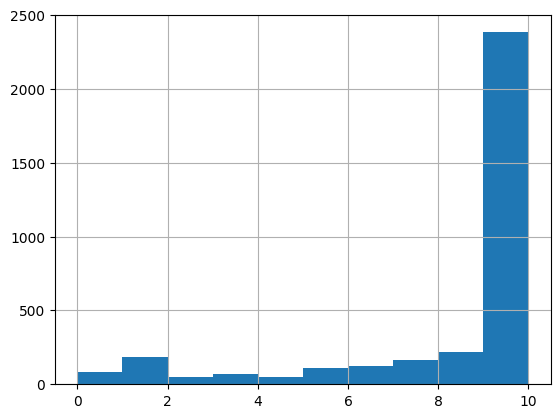

In [261]:
df['rating'].hist()

In [262]:
# y열을 추가하여 긍정 부정의 의견으로 나누었다.

def rating_to_label(rating):
    if rating > 6:
        return 1
    else:
        return 0
    
df['y'] = df['rating'].apply(lambda x: rating_to_label(x))

In [263]:
# rating에 따른 추가된 y열의 값을 확인

df.head()

,rating,review,y
0,10,인피니티 사가 최고의 마무리. 이보다 더 완벽할 순 없다.\n\n캡틴 아메리카에게 ...,1
1,10,아이언맨으로 시작된 10년 마블 영화 팬들에 대한 위대한 엔드 프리젠트.\r\n ...,1
2,10,"마블시네마틱유니버스의 대서사를 마무리 짓는 작품. 슈퍼 히어로와 액션이 난무하지만,...",1
3,10,11년의 긴 세월을 사랑 받아온 한편의 드라마를 어떻게하면 화려하게 장식 할 수 있...,1
4,9,&#39;인피니티워&#39;에서 엄청난 전투씬의 융단폭격을 퍼붓던 기조가 &#39;...,1


In [264]:
# 긍적적인 의견의 2768
# 부정적인 의견의 681

df["y"].value_counts()

y
1    2768
0     681
Name: count, dtype: int64

In [265]:
x = tf_idf_vect
y = df['y']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=1)

In [266]:
x_train.shape, y_train.shape

((2414, 3476), (2414,))

In [267]:
x_test.shape, y_test.shape

((1035, 3476), (1035,))

In [268]:
# fit in training set
lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)

# predict in test set
y_pred = lr.predict(x_test)

In [269]:
# classification result for test set

print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

accuracy: 0.83
precision: 0.83
recall: 0.99
F1: 0.90


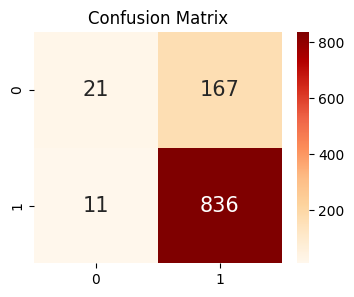

In [270]:
# confusion matrix
# 모델 평가결과를 살펴보면, 모델이 지나치게 긍정("1" = 836)로만 예측하는 경향이 있다.
# 부정 리뷰에 대한 에측 정확도를 높이기 위해 클래스 뷸균형 조정이 필요하다.


confu = confusion_matrix(y_true = y_test, y_pred = y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

In [271]:
# 총 3449개의 데이터 확인

df['y'].value_counts()

y
1    2768
0     681
Name: count, dtype: int64

In [272]:
# df의 인덱스 범위 내에서만 샘플링
df_index_range = list(range(3449))  # 0부터 3448까지의 인덱스 리스트 생성

# 긍정적인 의견과 부정적인 의견에서 무작위로 샘플링
positive_random_idx = df[df['y'] == 1].sample(681, random_state=12).index
negative_random_idx = df[df['y'] == 0].sample(681, random_state=12).index

# 인덱스가 df의 범위 내에 있는지 확인
positive_random_idx = [idx for idx in positive_random_idx if idx in df_index_range]
negative_random_idx = [idx for idx in negative_random_idx if idx in df_index_range]

# 인덱스 리스트 결합
random_idx = positive_random_idx + negative_random_idx

# tf_idf_vect에 적용
x = tf_idf_vect[random_idx]
y = df['y'].iloc[random_idx]

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)


In [273]:
x_train.shape, y_train.shape

((573, 3476), (573,))

In [274]:
x_test.shape, y_test.shape

((191, 3476), (191,))

In [275]:
# 클래스 불균형 조절 이후 모델 재학습

lr2 = LogisticRegression(random_state = 0)
lr2.fit(x_train, y_train)
y_pred = lr2.predict(x_test)

In [276]:
# classification result for test set

print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

accuracy: 0.74
precision: 0.74
recall: 0.99
F1: 0.84


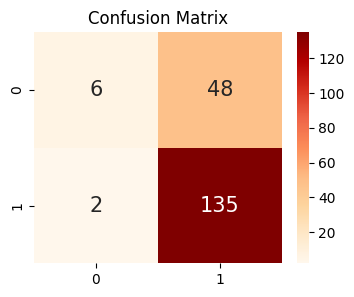

In [277]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confu = confusion_matrix(y_true = y_test, y_pred = y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

In [278]:
lr2.coef_

array([[ 0.04853957,  0.        ,  0.05198621, ...,  0.        ,
         0.        , -0.47982313]])

<BarContainer object of 3476 artists>

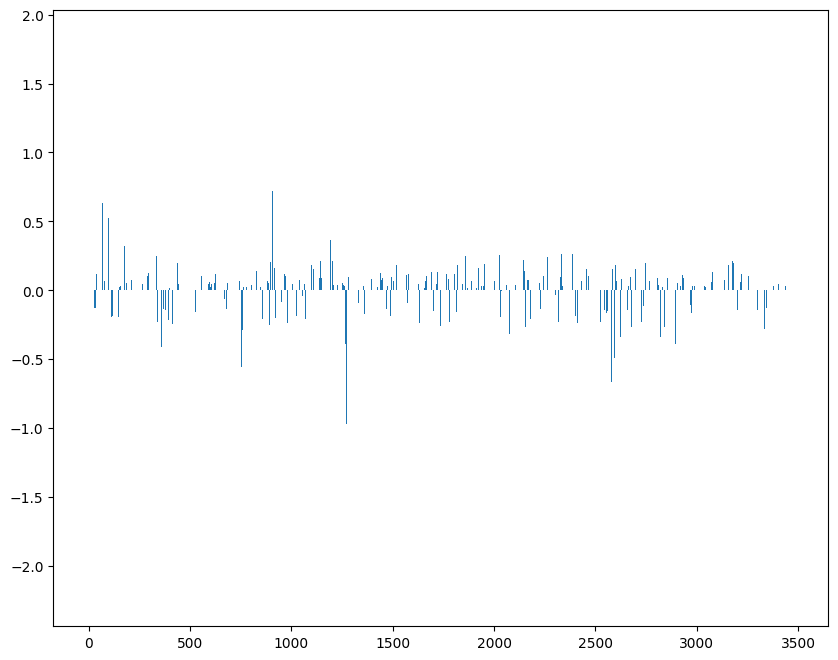

In [279]:
# print logistic regression's coef

plt.figure(figsize=(10, 8))
plt.bar(range(len(lr2.coef_[0])), lr2.coef_[0])

In [280]:
print(sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)[-5:])
# enumerate: 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환함

[(1.8290906168842056, 2931), (1.5323678964934682, 1941), (1.4386837312710208, 903), (0.8970483024503666, 957), (0.7184206081679194, 907)]
[(-1.3199893151459086, 1755), (-1.4407797729052978, 2778), (-1.6548416847589718, 2523), (-1.7210384954335163, 2941), (-2.2357316211502543, 2780)]


In [281]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = False)
coef_pos_index

[(1.8290906168842056, 2931),
 (1.5323678964934682, 1941),
 (1.4386837312710208, 903),
 (0.8970483024503666, 957),
 (0.7184206081679194, 907),
 (0.69840721941114, 2072),
 (0.6583787635568614, 1841),
 (0.6579627261025456, 1533),
 (0.6359061607892132, 68),
 (0.6354360600361542, 3471),
 (0.6286826538549395, 1725),
 (0.6257577497374404, 1268),
 (0.618150393928362, 923),
 (0.6044627948868403, 1730),
 (0.5993868157446987, 1436),
 (0.5738786024683474, 1678),
 (0.5729622310644484, 3011),
 (0.5708937920492638, 2819),
 (0.556501048094059, 306),
 (0.5319316227391112, 1584),
 (0.5315036464247841, 329),
 (0.525338203304209, 98),
 (0.5013892597154019, 1848),
 (0.49316464592706466, 345),
 (0.4908831672185031, 645),
 (0.4892127052767951, 544),
 (0.47756689590866147, 3273),
 (0.46918272739511024, 2474),
 (0.468393956515859, 2077),
 (0.4474644207339548, 3234),
 (0.43672743289576776, 2615),
 (0.4231204733020252, 576),
 (0.4067254623904756, 2198),
 (0.4030773201943852, 2341),
 (0.4009760407776315, 1520),
 

In [282]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
invert_index_vectorizer

{2402: '인피니티',
 1424: '사가',
 2931: '최고',
 903: '마무리',
 2330: '이보',
 3011: '캡틴',
 1812: '아메리카',
 2074: '영향',
 1256: '변화',
 3249: '하워드',
 1678: '스타크',
 244: '과거',
 1817: '아버지',
 3087: '토니',
 399: '기적',
 1841: '아이언맨',
 1031: '모두',
 2248: '위해',
 3467: '희생',
 3181: '평생',
 3409: '활동',
 2275: '은퇴',
 1694: '스티브',
 852: '로져스',
 1463: '산다',
 115: '개인',
 2819: '진짜',
 907: '마블',
 2077: '영화',
 1584: '소름',
 2891: '처음',
 321: '그것',
 3236: '핑거',
 1657: '스냅',
 957: '만큼',
 1436: '사랑',
 1941: '어벤져스',
 1946: '어셈블',
 1695: '스티븐',
 851: '로저스',
 3161: '페기',
 3001: '카터',
 677: '댄스',
 1012: '명대사',
 1913: '약속',
 1730: '시작',
 673: '대한',
 2002: '엔드',
 3223: '프리',
 2649: '젠트',
 3358: '현대',
 393: '기술',
 2831: '집약',
 1021: '명작',
 520: '년전',
 2433: '잉센',
 2354: '이제',
 3167: '페페',
 1719: '시네마',
 2253: '유니버스',
 1519: '서사',
 2474: '작품',
 1653: '슈퍼',
 3471: '히어로',
 1900: '액션',
 473: '난무',
 29: '가장',
 2733: '주제',
 917: '마음',
 2341: '이야기',
 2296: '의미',
 2503: '장면',
 2295: '의문',
 3298: '해결',
 2864: '차기',
 1879: '암시',
 1331:

In [283]:
# 키워드를 살펴보면

# 이 영화는 마블 팬들에게 최고의 마무리로 평가받으며, 
# 어벤져스 시리즈에 대한 사랑과 감동을 깊게 전달합니다. 
# 관객들은 특히 인생 영화라고 칭하며, 진짜 개꿀잼이라는 반응을 보이고 있습니다. 
# 영화의 결말과 캡틴 아메리카의 역할에 대한 찬사가 눈에 띄며, 
# 감동적인 이별과 히어로들의 활약에 대한 평가가 높습니다.

for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

최고 1.8290906168842056
어벤져스 1.5323678964934682
마무리 1.4386837312710208
만큼 0.8970483024503666
마블 0.7184206081679194
영웅 0.69840721941114
아이언맨 0.6583787635568614
선물 0.6579627261025456
감동 0.6359061607892132
히어로 0.6354360600361542
시리즈 0.6286826538549395
보고 0.6257577497374404
마지막 0.618150393928362
시작 0.6044627948868403
사랑 0.5993868157446987
스타크 0.5738786024683474
캡틴 0.5729622310644484
진짜 0.5708937920492638
굿바이 0.556501048094059
소름 0.5319316227391112


In [284]:
# 부정적인 키워드를 살펴보면

# 이 영화는 지루함과 실망감을 자아내며, 
# 드라마적 요소와 재미가 부족하다는 평가가 많습니다. 
# 많은 관객들이 최악이라고 평가하며, 기대에 미치지 못하는 부분들이 많이 보입니다. 
# 특히 영화의 초반부는 지루하고, 
# 시간이 지날수록 관객들의 흥미를 끌지 못하는 것으로 나타났습니다

for coef in coef_neg_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

지루함 -2.2357316211502543
최악 -1.7210384954335163
재미 -1.6548416847589718
지루 -1.4407797729052978
실망 -1.3199893151459086
노잼 -1.0315739667344552
시간 -1.011003723515771
보기 -0.9677322169769824
정신 -0.9177655147951376
내용 -0.8395716096940897
기대 -0.8096374352361121
졸음 -0.76546524363933
참고 -0.705505680928355
처음 -0.6890114078916135
미국 -0.6889186994331578
전쟁 -0.6631864752796157
엉망 -0.6069560977500851
광팬 -0.5943964049923136
초반 -0.5889902894122481
느낌 -0.5851079694890787
